# A08 Bootstrapping
### Paola Figueroa
### 20/ Nov/2025

Utiliza los conceptos aprendidos en los laboratorios de regresión y clasificación para encontrar el error estándar de los coeficientes de una regresión (lineal/logística) simple para los datasets de “Advertising” y “Default”.

Utiliza bootstrap para simular 1000 remuestreos de esos datasets y calcula la media de los coeficientes obtenidos al aplicarle regresión a cada remuestreo. Calcula la desviación estándar.

Compara los resultados obtenidos con el método visto en los laboratorios contra los resultados obtenidos con bootstrap. ¿Por qué podría haber diferencias en los resultados?

Agrega regularización L2 a los modelos del dataset de Advertising (optimiza el hiperparámetro). Utiliza ese valor del hiperparámetro para repetir el experimento de los 1000 remuestreos. Calcula la desviación estándar de los coeficientes obtenidos.

In [1]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from sklearn.tree import DecisionTreeRegressor

In [2]:
data1=pd.read_csv("Advertising.csv")
data2=pd.read_csv("Default.csv")

In [3]:
import numpy as np
np.random.seed(0)

In [4]:
data1.resample
data2.resample

<bound method NDFrame.resample of      default student      balance        income
0         No      No   729.526495  44361.625074
1         No     Yes   817.180407  12106.134700
2         No      No  1073.549164  31767.138950
3         No      No   529.250605  35704.493940
4         No      No   785.655883  38463.495880
...      ...     ...          ...           ...
9995      No      No   711.555020  52992.378910
9996      No      No   757.962918  19660.721770
9997      No      No   845.411989  58636.156980
9998      No      No  1569.009053  36669.112360
9999      No     Yes   200.922183  16862.952320

[10000 rows x 4 columns]>

In [6]:
x1 = data1['TV'].values.reshape(-1,1)
x2 = data1['radio'].values.reshape(-1,1)
x3 = data1['newspaper'].values.reshape(-1,1)
y = data1['sales']
n=len(y)
ones = np.ones([n,1])
X = np.hstack([ones,x1,x2,x3])
ols = sm.OLS(y, X)
results = ols.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           1.58e-96
Time:                        17:18:29   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.000       2.324       3.554
x1             0.0458      0.001     32.809      0.000       0.043       0.049
x2             0.1885      0.009     21.893      0.000       0.172       0.206
x3            -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
#Bootstrapping
n_bootstraps = 1000
coef_samples = np.zeros((n_bootstraps, X.shape[1]))
for i in range(n_bootstraps):
    sample_indices = np.random.choice(range(len(y)), size=len(y), replace=True)
    X_sample = X[sample_indices]
    y_sample = y.iloc[sample_indices]
    ols = sm.OLS(y_sample, X_sample)
    results = ols.fit()
    coef_samples[i, :] = results.params
coef_means = np.mean(coef_samples, axis=0)
print("Coeficientes medios"+str(coef_means))
#Desviación estandar de los coeficientes
coef_stds = np.std(coef_samples, axis=0)
print("Desviación estándar" + str(coef_stds))

Coeficientes medios[ 2.94921948e+00  4.56989139e-02  1.88851950e-01 -1.21988628e-03]
Desviación estándar[0.34589573 0.00193586 0.0107666  0.00654805]


In [8]:
data2['student_Yes'] = pd.get_dummies(data2['student'], drop_first=True)
X3 = data2[['balance', 'income', 'student_Yes']]
Y= data2['default']=='Yes'
X_multi = LogisticRegression()
X_multi.fit(X3, Y)

LogisticRegression()

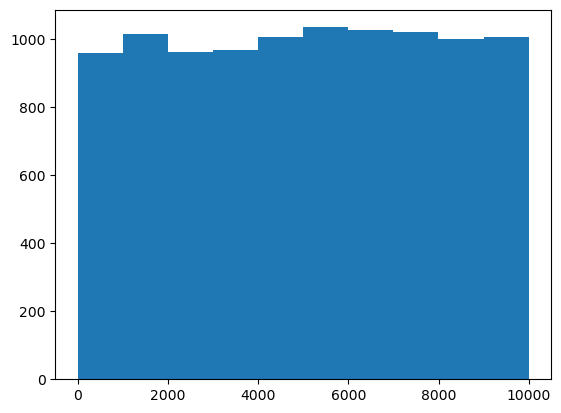

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.hist(sample_indices)
plt.show()

In [18]:
max(sample_indices)

9999

In [ ]:
X3.iloc[sample_indices, :]

,balance,income,student_Yes
764,419.476441,24001.512200,False
1340,1096.587037,47235.453130,False
7673,1127.435955,23495.565517,True
9017,0.000000,16156.029120,True
9810,861.590053,32901.010460,False
...,...,...,...
1576,29.175099,38871.478687,False
8016,956.446910,40740.329112,False
1325,872.856966,31471.545390,False
2492,59.132499,34162.235260,False


In [ ]:
Y.iloc[sample_indices]

5059    False
2362    False
2528    False
3975    False
5144    False
        ...  
6325    False
369     False
7921    False
3238     True
9689    False
Name: default, Length: 10000, dtype: bool

In [26]:
n_bootstraps = 1000
coef_samples = np.zeros((n_bootstraps, X3.shape[1] + 1)) 
for i in range(n_bootstraps):
    sample_indices = np.random.choice(range(len(Y)), size=len(Y), replace=True)
    X_sample = X3.iloc[sample_indices, :]    
    y_sample = Y[sample_indices]
    model = LogisticRegression() 
    model.fit(X_sample, y_sample)
    coef_samples[i, 0] = model.intercept_[0]
    coef_samples[i, 1:] = model.coef_[0]

coef_means = np.mean(coef_samples, axis=0)
coef_stds = np.std(coef_samples, axis=0)

print("Coeficientes medios:")
print(coef_means)
print("\nDesviación estándar:")
print(coef_stds)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Coeficientes medios:
[-1.09439992e+01  5.75294014e-03  3.97494854e-06 -6.13974824e-01]

Desviación estándar:
[4.97787642e-01 2.34426955e-04 8.01397970e-06 2.23203563e-01]


In [27]:
# tablita linda
coef_means_adv = np.array([2.94921948e+00, 4.56989139e-02, 1.88851950e-01, -1.21988628e-03])
coef_stds_adv = np.array([0.34589573, 0.00193586, 0.0107666, 0.00654805])
variables_adv = ['Intercepto', 'TV', 'Radio', 'Newspaper']

df_adv = pd.DataFrame({
    'Coeficiente Medio': coef_means_adv,
    'Desviación Estándar': coef_stds_adv
}, index=variables_adv)


coef_means_def = np.array([-1.09439992e+01, 5.75294014e-03, 3.97494854e-06, -6.13974824e-01])
coef_stds_def = np.array([4.97787642e-01, 2.34426955e-04, 8.01397970e-06, 2.23203563e-01])
variables_def = ['Intercepto', 'balance', 'income', 'student_Yes']

df_def = pd.DataFrame({
    'Coeficiente Medio': coef_means_def,
    'Desviación Estándar': coef_stds_def
}, index=variables_def)

In [29]:
print("# --- TABLA 1: Advertising (OLS) ---")
print(df_adv)

print("\n# --- TABLA 2: Default (Regresión Logística) ---")
print(df_def)

# --- TABLA 1: Advertising (OLS) ---
            Coeficiente Medio  Desviación Estándar
Intercepto           2.949219             0.345896
TV                   0.045699             0.001936
Radio                0.188852             0.010767
Newspaper           -0.001220             0.006548

# --- TABLA 2: Default (Regresión Logística) ---
             Coeficiente Medio  Desviación Estándar
Intercepto          -10.943999             0.497788
balance               0.005753             0.000234
income                0.000004             0.000008
student_Yes          -0.613975             0.223204


In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

search_spaces = {
    'alpha': Real(1e-2, 100, prior='log-uniform')
}
bayes_search = BayesSearchCV(
    estimator=Ridge(),
    search_spaces=search_spaces,
    n_iter=50,              
    cv=10,                   
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(X_scaled, y)

best_model = bayes_search.best_estimator_
best_alpha = bayes_search.best_params_['alpha']

coefs_base = [best_model.intercept_] + list(best_model.coef_.ravel())
medias_ridge = np.mean(coefs_base, axis=0)
std_ridge = np.std(coefs_base, axis=0)

print(f'mejor alpha {best_alpha}')
print(f'La media de los coeficientes con ridge es de: {medias_bootstrap}')
print(f'La desviacion estandar de los coeficientes con ridge es de: {std_bootstrap}')

n_iterations = 1000
coefs_ridge_bootstrap = []
model_ridge = Ridge(alpha=best_alpha)


for i in range(n_iterations):
    X_res, y_res = resample(X_scaled, y, replace=True, random_state=i)

    model_ridge.fit(X_res, y_res)

    iter_coefs = [model_ridge.intercept_] + list(model_ridge.coef_.ravel())
    coefs_ridge_bootstrap.append(iter_coefs)

coefs_ridge_bootstrap = np.array(coefs_ridge_bootstrap)
medias_ridge = np.mean(coefs_ridge_bootstrap, axis=0)
std_ridge = np.std(coefs_ridge_bootstrap, axis=0)

print(f'La media de los coeficientes con ridge y bootstarp es de: {medias_bootstrap}')
print(f'La desviacion estandar de los coeficientes con ridge y bootstarp es de: {std_bootstrap}')

mejor alpha 1.2063951043908536


NameError: name 'medias_bootstrap' is not defined